### LC Loan Analysis

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Define column subset and import data
colSubset = [
    'loan_amnt'
    , 'funded_amnt'
    , 'term'
    , 'int_rate'
    , 'grade'
    , 'annual_inc'
    , 'issue_d'
    , 'dti'
    , 'revol_bal'
    , 'total_pymnt'
    , 'loan_status'
]

data = pd.read_csv('.\loan.csv', usecols = colSubset)

In [3]:
# Some summary stats
print('~~SUMMARY STATISTICS ON QUANTITATIVE VARIABLES~~\n\n', data.describe(), '\n\n')

# Count # and % nulls in each column
print('~~STATISTICS ON NULL VALUES FOR EACH COLUMN~~\n\n', 
    pd.concat(
        [
            data.isna().sum()/len(data.index)
            , data.isnull().sum()
        ]
        , axis=1
        , keys = ['Percent Null', 'Null Cnt']
    )
, '\n\n')

# Print column datatypes
print('~~DATA TYPES OF EACH COLUMN~~\n\n', data.dtypes)

# See example data
print('\n\n~~FIVE ROWS OF SAMPLE DATA~~\n\n', data.head(5))

~~SUMMARY STATISTICS ON QUANTITATIVE VARIABLES~~

            loan_amnt    funded_amnt       int_rate    annual_inc  \
count  887379.000000  887379.000000  887379.000000  8.873750e+05   
mean    14755.264605   14741.877625      13.246740  7.502759e+04   
std      8435.455601    8429.897657       4.381867  6.469830e+04   
min       500.000000     500.000000       5.320000  0.000000e+00   
25%      8000.000000    8000.000000       9.990000  4.500000e+04   
50%     13000.000000   13000.000000      12.990000  6.500000e+04   
75%     20000.000000   20000.000000      16.200000  9.000000e+04   
max     35000.000000   35000.000000      28.990000  9.500000e+06   

                 dti     revol_bal    total_pymnt  
count  887379.000000  8.873790e+05  887379.000000  
mean       18.157039  1.692079e+04    7558.826684  
std        17.190626  2.242679e+04    7871.243336  
min         0.000000  0.000000e+00       0.000000  
25%        11.910000  6.443000e+03    1914.590000  
50%        17.650000  1.

### Visualize correlations and distributions between variables using pairplot

C:\Users\Sager\Anaconda3\envs\uw37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


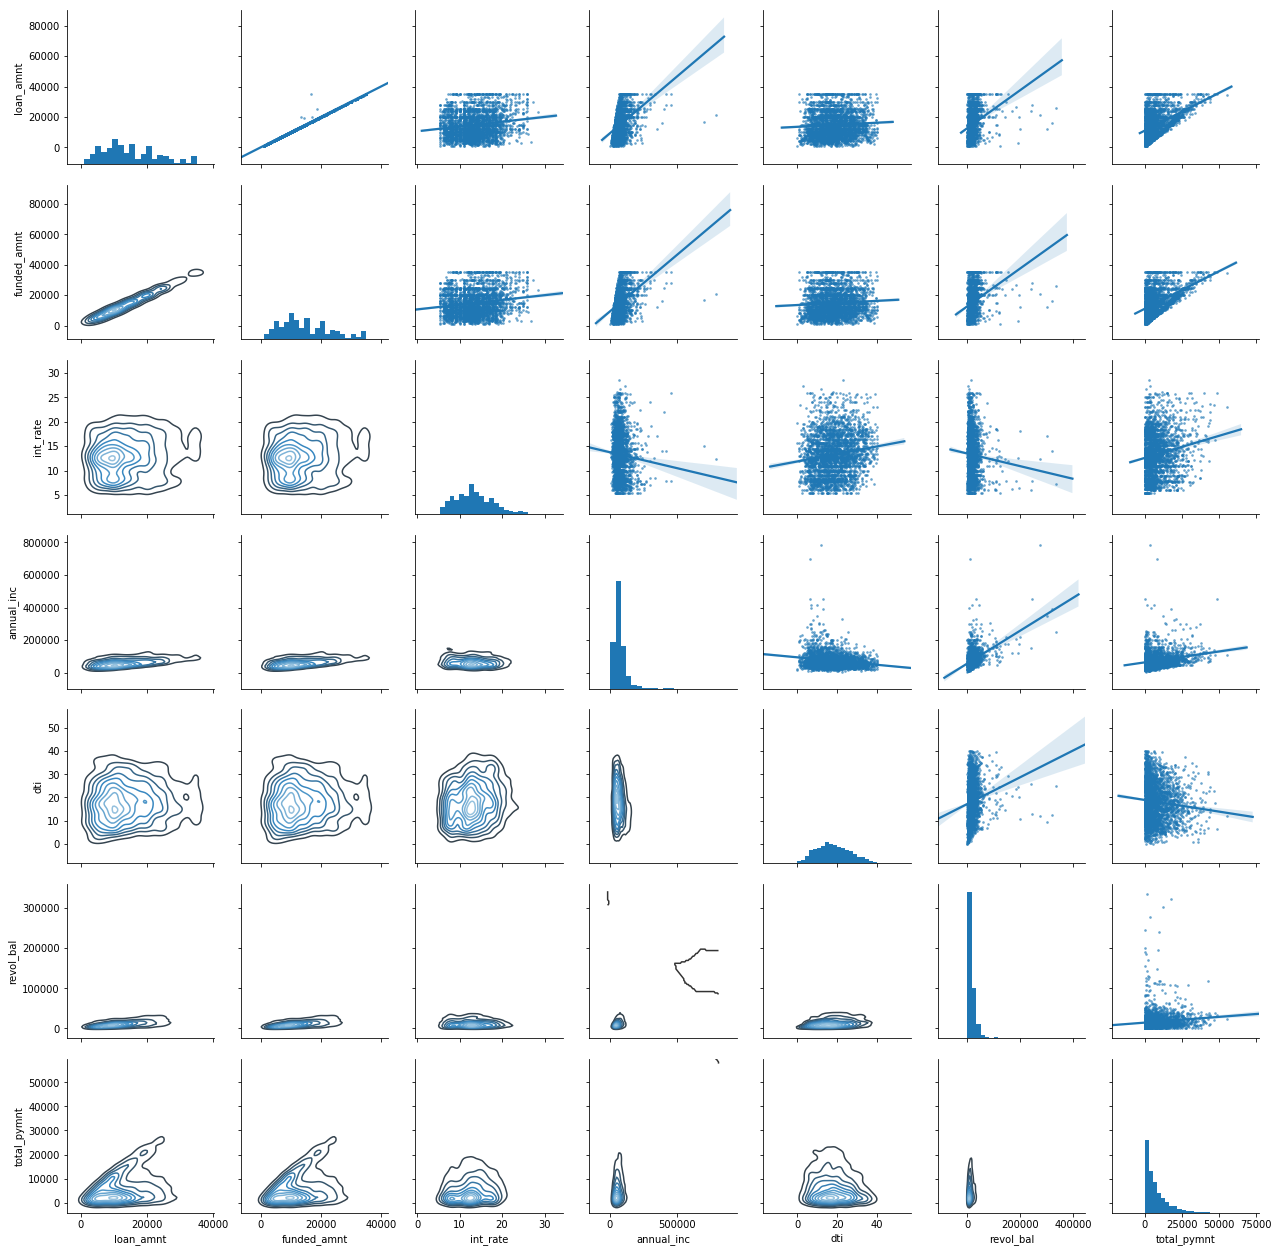

In [4]:
# Downsample before visualizing, as 800k+ rows is a lot for these visualizations
grd = sns.PairGrid(data.sample(3000))
grd.map_diag(plt.hist, bins=20)
grd.map_lower(sns.kdeplot, cmap='Blues_d')
grd.map_upper(sns.regplot, scatter_kws={'alpha': 0.5, 's': 3})

In [5]:
# Visualize categorical data - term, grade, issue_d, loan_status
# Convert issue_d to datetime to view counts by month and year properly
data['issue_d'] = pd.to_datetime(data.issue_d)

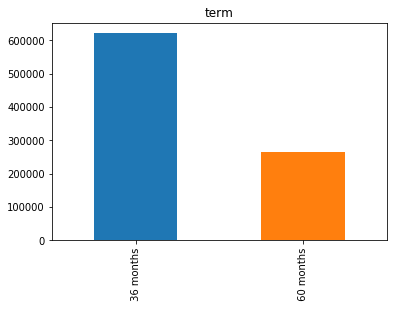

In [6]:
# Create visualizations
term_cnts = pd.value_counts(data['term'])
term_cnts.plot.bar(title='term')

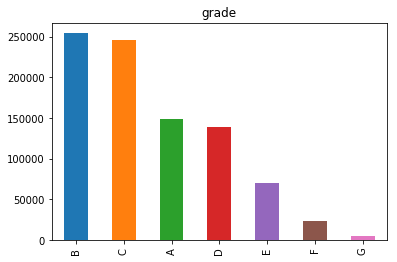

In [7]:
grade_cnts = pd.value_counts(data['grade'])
grade_cnts.plot.bar(title='grade')

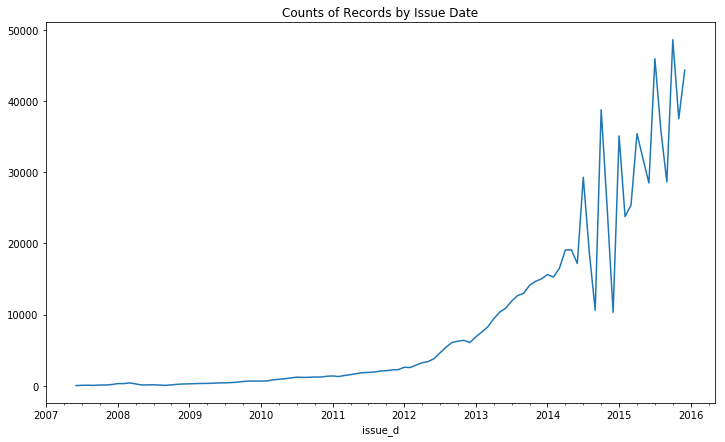

In [8]:
# Look at counts by issue date
data.groupby(['issue_d']).count()['loan_amnt'].plot(title='Counts of Records by Issue Date', figsize=[12,7])

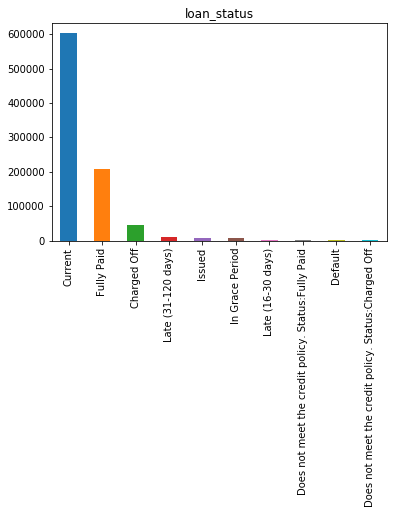

In [9]:
term_cnts = pd.value_counts(data['loan_status'])
term_cnts.plot.bar(title='loan_status')

### Initial Notes on Data (Distribution, Cleaning)

Here, I describe the distribution of each variable and the steps I will take to clean the data based on that variable.

#### 'loan_amnt': 
* The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
* Range: 500 - 35,000
* Mean: 14,755
* Median: 13,000
* No outliers or null values to remove
* Distribution: Mildly right-skewed; no particular peak, except at round numbers (e.g., 10k, 20k)

#### 'funded_amnt': 
* The total amount committed to that loan at that point in time.
* Range: 500 - 35,000
* Mean: 14,742
* Median: 13,000
* No outliers or null values to remove
* Distribution: Mildly right -skewed; no particular peak, except at round numbers (e.g., 10k, 20k) - must be a human thing to pick these round numbers
* Almost identical to loan_amnt, suggesting that most people probably get the loan they ask for

#### 'term':
* The number of payments on the loan. Values are in months and can be either 36 or 60.
* A little over 2/3 of the loans have a 36 month term, the rest have 60.
* No null values to remove

#### 'int_rate': 
* Interest Rate on the loan
* Range: 5.32 - 28.99
* Mean: 13.25
* Median: 12.99
* No outliers or null values to remove
* Distribution: Slightly right-skewed; wide and relatively flat

#### 'grade': 
* LC assigned loan grade
* Most loans are either B or C grade, with a lower number dropping away from these in roughly equal numbers, and a small number of very poorly graded loans.

#### 'annual_inc': 
* The self-reported annual income provided by the borrower during registration.
* Range: 0 - 9,500,000
* Mean: 75,028
* Median: 65,000
* Annual income of 0 seems wrong, though loan could be with another individual - will keep
* Remove where values are null (very few records, so will not worry about interpolation)
* Also will remove outliers - according to the histogram, anything above $1M is probably the outlier. Intuitively, I would think making loan determinations for individuals making very high incomes is a different process, and we don't have enough of a sample to work with them.

#### 'issue_d': 
* The month which the loan was funded
* Loans were issued from 2007 to 2015. 

#### 'dti': 
* A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
* Range: 0 - 9999
* Mean: 18.16
* Median: 17.65
* Seems like this ratio is expressed as a percent between 0 and 100. 
* No null values to remove.
* Outliers: Values greater than 100 do not make sense (how can one have debt payments greater than self-reported income and still exist in this dataset of loans given to the individual?), so they will be removed. 0 values, on the other hand, do make sense, as this excludes certain types of debt obligations. The distribution seems to have few if any values beyond 40; I will remove values beyond 50.
* I would hypothesize that a higher value for this means the loan is riskier.

#### 'revol_bal': 
* Total credit revolving balance
* Range: 0 - 2,904,836
* Mean: 16,921
* Median: 11,875
* Will need to make sure outliers are removed - 2.9M seems much too high given the max funded_amnt. Given histogram above, will remove values above $500K

#### 'total_pymnt': 
* Payments received to date for total amount funded
* Range: 0 - 57,777
* Mean: 7,559
* Median: 4,895
* No null values or outliers to remove

#### 'loan_status': 
* Current status of the loan
* 600k out of almost 900k total loans are current. 200k are paid off, and smaller numbers are in various stages of being late or in default. These classes are highly imbalanced.

#### Next step:
Clean data as specified above, then redo the pairplot visualizations (to see distribution after removing outliers)

In [10]:
data = data.dropna(how='any')[(data['annual_inc'] < 1000000) & (data['dti'] < 50) & (data['revol_bal'] < 500000)]

C:\Users\Sager\Anaconda3\envs\uw37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


C:\Users\Sager\Anaconda3\envs\uw37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


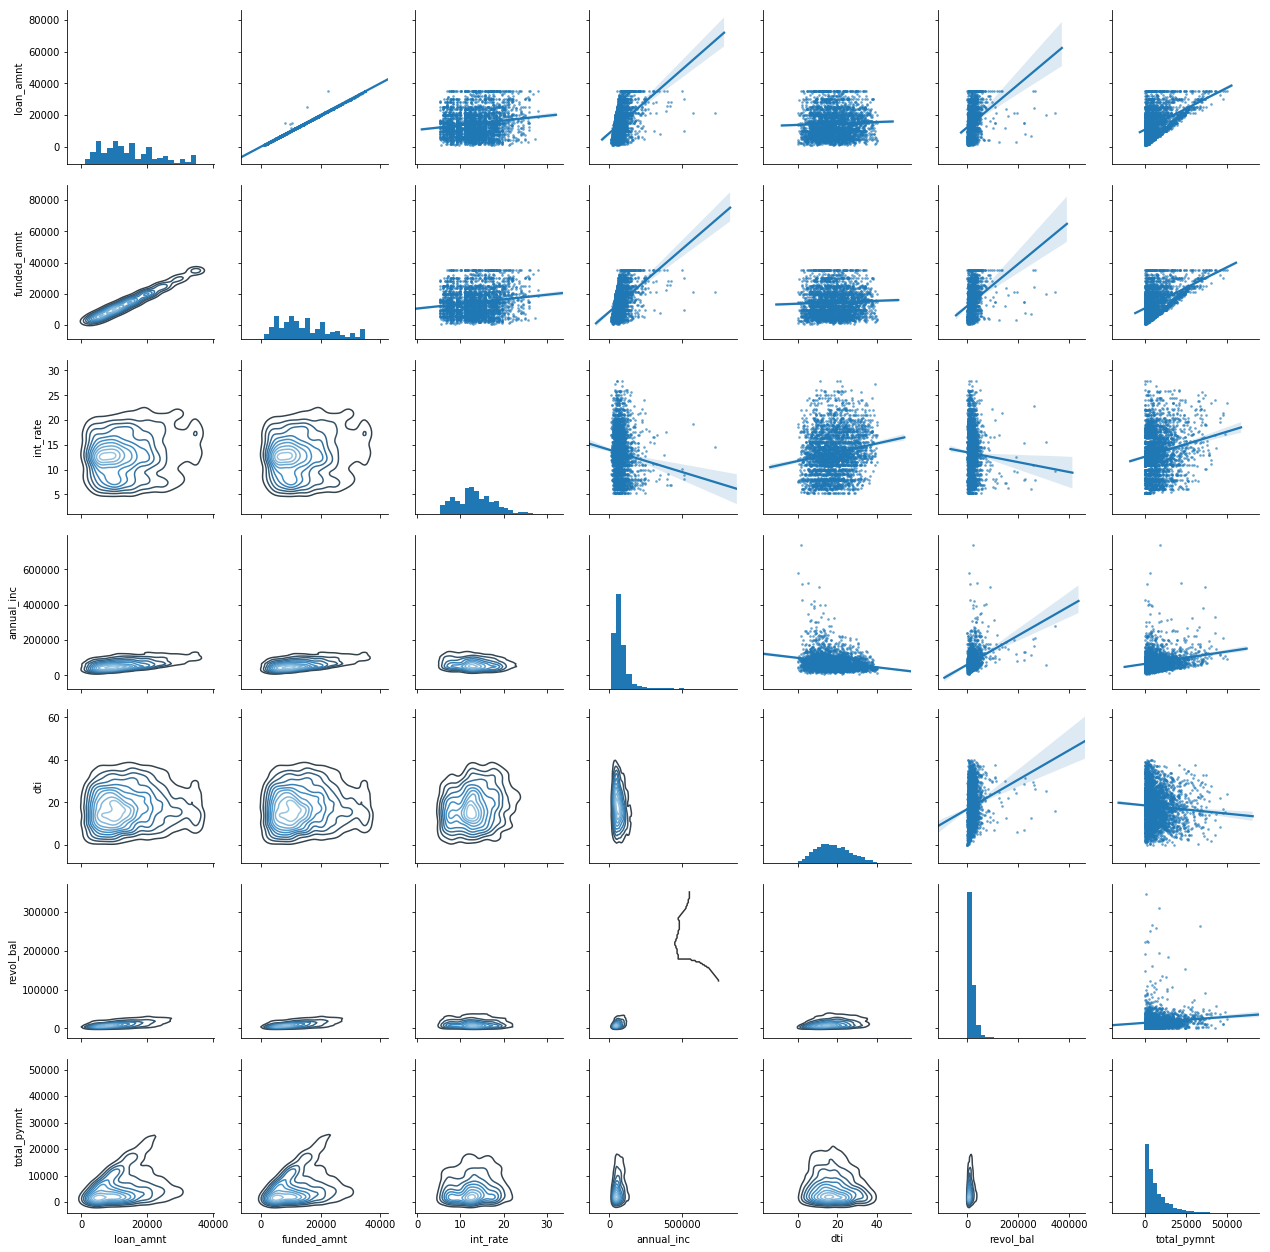

In [11]:
# Downsample before visualizing, as 800k+ rows is a lot for these visualizations
grd = sns.PairGrid(data.sample(3000))
grd.map_diag(plt.hist, bins=20)
grd.map_lower(sns.kdeplot, cmap='Blues_d')
grd.map_upper(sns.regplot, scatter_kws={'alpha': 0.5, 's': 3})

### Evaluating loans with 36-month terms

In [12]:
# Eliminating loans with less than 36 months of data - will use latest issue date as cutoff
date_cutoff = max(data['issue_d']) - pd.tseries.offsets.DateOffset(years=3)
d36 = data[(data['issue_d'] <= date_cutoff)]
print('NUMBER OF ROWS WITH AT LEAST 36 MONTHS OF DATA: {}'.format(len(d36)))

NUMBER OF ROWS WITH AT LEAST 36 MONTHS OF DATA: 95871


In [13]:
# Create new column with status assumptions
d36.loc[d36['loan_status'] != 'Fully Paid', 'loan_status'] = 'Default'

C:\Users\Sager\Anaconda3\envs\uw37\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [14]:
# Calculate percent of loans paid off
percent_fully_paid = 100*sum(d36['loan_status']=='Fully Paid')/len(d36)
print('PERCENT OF LOANS WITH 36 MONTHS OF DATA THAT ARE FULLY PAID: {}%'.format(percent_fully_paid))

PERCENT OF LOANS WITH 36 MONTHS OF DATA THAT ARE FULLY PAID: 76.78025680341293%


In [15]:
# Create columns for origination year and estimate of annualized rate of return
d36['issue_year'] = d36['issue_d'].dt.year

import math
# Function to properly calculate cubic root of negative numbers, grrr Python
def cube_root(i):
    return math.copysign(abs(i)**(1/3), i)

d36['ann_rate_return_est'] = (d36['total_pymnt'] - d36['funded_amnt']).apply(cube_root) - 1

C:\Users\Sager\Anaconda3\envs\uw37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Sager\Anaconda3\envs\uw37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [16]:
# Find grade and year with highest default rate
default_rate_grouped = (
    d36.loc[d36['loan_status']=='Default', :].groupby(['grade', 'issue_year']).count()
    /d36.groupby(['grade', 'issue_year']).count()
).loc[:, ['loan_amnt']]

default_rate_grouped.loc[default_rate_grouped['loan_amnt'] == default_rate_grouped['loan_amnt'].max()]

,,loan_amnt
grade,issue_year,
G,2007,1.0


The grade and year with the highest default rate is grade G from 2007, with a 100% default rate.

In [17]:
# Find bucketed annualized rate of return using same buckets as above
ann_rate_return_est = (
    d36.groupby(['grade', 'issue_year']).mean()
).loc[:, ['ann_rate_return_est']]
ann_rate_return_est

ann_rate_return_est
grade issue_year                     
A     2007                   5.838941
      2008                   6.092697
      2009                   6.554147
      2010                   6.871859
      2011                   6.492864
      2012                   7.002001
B     2007                   4.953986
      2008                   5.052747
      2009                   7.079964
      2010                   7.497945
      2011                   7.425399
      2012                   6.834624
C     2007                   3.460965
      2008                   4.449574
      2009                   6.746758
      2010                   7.233631
      2011                   7.057324
      2012                   6.215920
D     2007                   2.804732
      2008                   3.408861
      2009                   6.883463
      2010                   7.183799
      2011                   6.964871
      2012                   6.213809
E     2007                   2.801823
      2008                   4.276742
      2009                   6.306888
      2010                   6.958483
      2011                   7.830414
      2012                   5.299366
F     2007                  -2.430021
      2008                   2.291126
      2009                   4.825020
      2010                   6.674880
      2011                   7.325541
      2012                   5.648949
G     2007                  -0.636962
      2008                   3.767458
      2009                   4.242603
      2010                   6.635039
      2011                   6.869905
      2012                   4.549880

### Building a Logistic Regression Model to Predict Default
To build this, I will define my features (explaining new features), split the data into a train and test set stratified by year and loan status, build the model using cross validation of important hyperparameters, validate the model using a confusion matrix on the test set, and then note findings.
#### Features
* loan_amnt
* funded_amnt
* loan_funded_diff: funded_amnt - loan_amnt
    * If the amount funded changed (perhaps decreasing) from the original requested loan amount, it may be a sign that the lender views the loan as risky
* annual_inc
* int_rate
    * Interest rate is a quantitative measure of risk, so I will use this instead of grade, which is discrete and thus conveys less information
* dti
* revol_bal
* rb_to_inc: revol_bal/annual_inc
    * People who hold high revolving balances relative to their income may be riskier
* issue_d (not used except for stratification)
    * I will not use year as in input feature, as the year itself should not convey useful information about risk, but rather it will be data about the year (macro indicators, etc.). Using year as a feature would not make sense if immediately investing in a loan upon origination and holding to maturity, because the model isn't trained on future years!

In [18]:
# Create new dataframe and generate new features
d36m = d36[[
    'loan_amnt', 'funded_amnt', 'annual_inc', 'int_rate', 'dti', 'revol_bal', 'issue_year', 'loan_status'
]].copy()
d36m['loan_funded_diff'] = d36m['funded_amnt'] - d36m['loan_amnt']
d36m['rb_to_inc'] = d36m['revol_bal']/(d36m['annual_inc'] + 1)
d36m.head()

,loan_amnt,funded_amnt,annual_inc,int_rate,dti,revol_bal,issue_year,loan_status,loan_funded_diff,rb_to_inc
0,5000.0,5000.0,24000.0,10.65,27.65,13648.0,2011,Fully Paid,0.0,0.568643
1,2500.0,2500.0,30000.0,15.27,1.00,1687.0,2011,Default,0.0,0.056231
2,2400.0,2400.0,12252.0,15.96,8.72,2956.0,2011,Fully Paid,0.0,0.241247
3,10000.0,10000.0,49200.0,13.49,20.00,5598.0,2011,Fully Paid,0.0,0.113778
4,3000.0,3000.0,80000.0,12.69,17.94,27783.0,2011,Default,0.0,0.347283


In [19]:
# Split data into train and test set
from sklearn.model_selection import train_test_split

d36m_in = d36m.drop(columns=['loan_status'])
d36m_out = d36m[['loan_status']]
d36m_stratify = d36m[['loan_status', 'issue_year']]
d36m_in_train, d36m_in_test, d36m_out_train, d36m_out_test = train_test_split(
    d36m_in, d36m_out, test_size = 0.25, random_state = 42, stratify = d36m_stratify
)

C:\Users\Sager\Anaconda3\envs\uw37\lib\site-packages\sklearn\utils\__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [20]:
# Define logistic regression parameters
from sklearn.linear_model import LogisticRegressionCV

# L2 ensures no variables are removed
# Balanced class weight is not critical because class isn't highly imbalanced, but still good practice
lr_cv = LogisticRegressionCV(
    penalty='l2', fit_intercept=True, class_weight='balanced', cv=5
    , random_state=42, n_jobs = -2, verbose = 2
)

#### Model validation
I use cross-valication with 5 folds to validate model parameters, which in this case is the regularization cost parameter. The model creates a grid on the logarithmic scale of the cost parameter (where smaller values mean stronger regularization) and fits multiple models exhaustively using all but 1 of the folds (random, nonoverlapping partitions of the data), assessing performance on the remaining fold. I use L2 (ridge) regularization as it's results tend to be more stable than L1 if there is high multicolinearity. I also balance the weights of the classes in order to ensure the algorithm attempts to fit to the minority class (aka defaults) better.

In [21]:
# Fit model
mdl = lr_cv.fit(d36m_in_train, d36m_out_train)

C:\Users\Sager\Anaconda3\envs\uw37\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    2.1s finished


In [22]:
# Evaluate performance
print('Overall accuracy on test set: {}\n\n'.format(mdl.score(d36m_in_test, d36m_out_test)))

from sklearn.metrics import confusion_matrix

# Create predictions for test set
d36m_pred_test = mdl.predict(d36m_in_test)

# Create confusion matrix, isolate elements, and calculate important values
cnf_mat = confusion_matrix(d36m_out_test, d36m_pred_test, labels=['Fully Paid', 'Default']) # Negative class first
tn, fp, fn, tp = cnf_mat.ravel()
print('CONFUSION MATRIX (Predicted P vs. Observed O)\n\n\tFully Paid (P)\tDefault (P)\n\nFully Paid (O)\t{}\t{}\n\nDefault (O)\t{}\t{}'.format(tn, fp, fn, tp))
print('\n\nDEFAULT PRECISION: {0:.2%}\nFULLY PAID PRECISION: {1:.2%}\nDEFAULT RECALL: {2:.2%}\nFULLY PAID RECALL: {3:.2%}'.format(
    tp/(tp+fp), tn/(tn+fn), tp/(tp+fn), tn/(tn+fp)
))
print('\n\nNaive guess accuracy (aka, guessing everything is the majority class and there are no defaults): {}'.format(
    (tn+fp)/(tn+fp+fn+tp)
))

Overall accuracy on test set: 0.6443174232309746


CONFUSION MATRIX (Predicted P vs. Observed O)

	Fully Paid (P)	Default (P)

Fully Paid (O)	11941	6462

Default (O)	2063	3502


DEFAULT PRECISION: 35.15%
FULLY PAID PRECISION: 85.27%
DEFAULT RECALL: 62.93%
FULLY PAID RECALL: 64.89%


Naive guess accuracy (aka, guessing everything is the majority class and there are no defaults): 0.7678154205607477


#### Analysis
The model was effective, though perhaps not ideal, for several reasons:
* Although accuracy on the test set was below naive accuracy, the model has > 60% recall for both defaults and fully paid loans. This means that this percent of the total amount of defaults in the world are captured by the model. The model conveys more information than the naive guess despite lower total accuracy.
* Given the model parameters, it seems the current values are not effective for predicting when a default might happen with high accuracy. The default precision is only 35% - when the model says a default will occur, it is right only 35% of the time. This would lead my model to be financially conservative, causing the investor to reject many loans that will not default (at least using the default 50% probability cutoff of the model).
* Recall is very close between default and fully paid most likely because I balanced the classes using weights and used overall accuracy as the CV scorer (i.e., how to evaluate hyperparameters during CV).
* Because the model conveys more information than a naive guess, it is a good first tackle of the problem. Also, this model will avoid over half of all defaults that occur, which can potentially save the investor a lot of money.
* If one wanted to use this model right now, one might want to define an ideal default recall and adjust the probability decision boundary before use. Recall is ideal here because the investor probably wants a portfolio-level assurance that the risk of default is minimized, even at the cost of lack of precision. 